In [1]:
# Automating the creation of test data paths
def generate_file_paths(base_path, file_name_pattern, start, end, extension):
    """
    Generates a list of file paths with a specified pattern.
    
    Args:
    - base_path (str): The base directory path.
    - file_name_pattern (str): The pattern of the file name with placeholders for numbering.
    - start (int): The starting number for file names.
    - end (int): The ending number for file names.
    - extension (str): The file extension.
    
    Returns:
    - List of file paths.
    """
    return [f"{base_path}/{file_name_pattern.format(str(i).zfill(4))}.{extension}" for i in range(start, end + 1)]

# Automating GIF files
sample_gif_files = [
    f"input_data/sample_gif/SampleGIFImage_{size}kbmb.gif"
    for size in [40, 135, 350]
]

# Automating JPG files
sample_jpg_files = [
    f"input_data/sample_jpg/SampleJPGImage_{size}mbmb.jpg"
    for size in [1, 2, 5, 10, 15, 20, 30]
] + [
    f"input_data/sample_jpg/SampleJPGImage_{size}kbmb.jpg"
    for size in [50, 100, 200, 500]
]

# Automating PDF files
sample_pdf_files = [f"input_data/sample_pdf/SamplePDFFile_{size}mb.pdf" for size in [5]]

# Automating PNG files
sample_png_files = [
    f"input_data/sample_png/SamplePNGImage_{size}mbmb.png"
    for size in [1, 3, 5, 10, 20, 30]
] + [
    f"input_data/sample_png/SamplePNGImage_{size}kbmb.png"
    for size in [100, 200, 500]
]

# Automating PPT files
sample_ppt_files = [
    f"input_data/sample_ppt/SamplePPTFile_{size}kb.ppt"
    for size in [500, 1000]
]

# Automating Text files
sample_text_files = [
    f"input_data/sample_text/text_{size}.txt"
    for size in [10, 100, 1000, 10000, 100000, 1000000, 10000000]
]

# Automating Video files
video_resolutions = ['360x240', '640x360', '720x480', '1280x720']
video_sizes = [1, 2, 5, 10, 20, 30]
sample_video_files = [
    f"input_data/sample_video/SampleVideo_{res}_{size}mb.mp4"
    for res in video_resolutions
    for size in video_sizes
]

# Automating ZIP files
sample_zip_files = [
    f"input_data/sample_zip/SampleZIPFile_{size}mbmb.zip"
    for size in [10, 20, 30, 50, 100]
]

# Automating Vectors
vectors = generate_file_paths(
    base_path="input_data/vectors",
    file_name_pattern="byte{}",
    start=0,
    end=195,
    extension="dat"
)

In [6]:
import os
import random
import string
import numpy as np
import pandas as pd
from scipy.stats import entropy, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from cryptography.hazmat.primitives import hashes
from tabulate import tabulate

# Helper function to compute hash using a specific algorithm
def compute_hash(data, algorithm):
    if algorithm == "MD5":
        digest = hashes.Hash(hashes.MD5())
    elif algorithm == "SHA-1":
        digest = hashes.Hash(hashes.SHA1())
    elif algorithm == "SHA-256":
        digest = hashes.Hash(hashes.SHA256())
    elif algorithm == "SHA3-256":
        digest = hashes.Hash(hashes.SHA3_256())
    elif algorithm == "Blake2b":
        digest = hashes.Hash(hashes.BLAKE2b(64))
    else:
        raise ValueError("Unsupported algorithm")
    digest.update(data)
    return digest.finalize()

# Helper function to calculate entropy of hash values
def calculate_entropy(hash_bytes):
    _, counts = np.unique(list(hash_bytes), return_counts=True)
    return entropy(counts, base=2)  # Base-2 entropy

# Helper function to read files as binary
def read_file(file_path):
    with open(file_path, "rb") as f:
        return f.read()

# Test data generators
def generate_random_strings(num_strings, string_length):
    return [
        "".join(random.choices(string.ascii_letters + string.digits, k=string_length)).encode()
        for _ in range(num_strings)
    ]

def generate_random_binary_files(num_files, file_size_kb):
    return [os.urandom(file_size_kb * 1024) for _ in range(num_files)]

def generate_number_sequences(num_sequences, sequence_length):
    return [bytes(range(sequence_length)) for _ in range(num_sequences)]

# Main testing function
def test_entropy(algorithms, files, random_strings, random_binaries, number_sequences):
    results = {alg: [] for alg in algorithms}

    # Process files
    for file in files:
        data = read_file(file)
        for alg in algorithms:
            hash_bytes = compute_hash(data, alg)
            results[alg].append(calculate_entropy(hash_bytes))

    # Process random strings
    for data in random_strings:
        for alg in algorithms:
            hash_bytes = compute_hash(data, alg)
            results[alg].append(calculate_entropy(hash_bytes))

    # Process random binary files
    for data in random_binaries:
        for alg in algorithms:
            hash_bytes = compute_hash(data, alg)
            results[alg].append(calculate_entropy(hash_bytes))

    # Process number sequences
    for data in number_sequences:
        for alg in algorithms:
            hash_bytes = compute_hash(data, alg)
            results[alg].append(calculate_entropy(hash_bytes))

    return results

# Perform statistical analysis
def analyze_entropy_results(results):
    alg_entropies = [results[alg] for alg in results]
    f_stat, p_value = f_oneway(*alg_entropies)

    analysis = {
        "average_entropies": {alg: np.mean(entropies) for alg, entropies in results.items()},
        "f_statistic": f_stat,
        "p_value": p_value,
        "significant": p_value < 0.05
    }
    return analysis

# Perform Tukey's HSD test
def perform_tukey_hsd(results):
    # Flatten results into a single array with corresponding labels
    data = []
    groups = []
    for alg, entropies in results.items():
        data.extend(entropies)
        groups.extend([alg] * len(entropies))
    
    # Perform Tukey's HSD
    tukey = pairwise_tukeyhsd(endog=data, groups=groups, alpha=0.05)
    
    # Convert Tukey results into a pandas DataFrame
    tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    return tukey_df

# Configurations
algorithms = ["MD5", "SHA-1", "SHA-256", "SHA3-256", "Blake2b"]
test_files = (
    sample_gif_files + sample_jpg_files + sample_pdf_files +
    sample_png_files + sample_ppt_files + sample_text_files +
    sample_video_files + sample_zip_files + vectors
)
random_strings = generate_random_strings(num_strings=50, string_length=50)
random_binaries = generate_random_binary_files(num_files=50, file_size_kb=10)
number_sequences = generate_number_sequences(num_sequences=50, sequence_length=256)

# Run tests
results = test_entropy(algorithms, test_files, random_strings, random_binaries, number_sequences)

# Analyze results
analysis = analyze_entropy_results(results)

# Perform Tukey's HSD
tukey_results = perform_tukey_hsd(results)

# Create tables for results
entropy_table = pd.DataFrame({
    "Algorithm": algorithms,
    "Average Entropy (bits)": [np.mean(results[alg]) for alg in algorithms]
})

anova_table = pd.DataFrame({
    "Metric": ["F-Statistic", "P-Value", "Significant Difference"],
    "Value": [analysis["f_statistic"], analysis["p_value"], analysis["significant"]]
})

# Display tables
print("\nEntropy Results Table:")
print(tabulate(entropy_table, headers="keys", tablefmt="grid"))

print("\nANOVA Analysis Table:")
print(tabulate(anova_table, headers="keys", tablefmt="grid"))

# Display Tukey HSD results
print("\nTukey HSD Pairwise Comparisons:")
print(tabulate(tukey_results, headers="keys", tablefmt="grid"))



Entropy Results Table:
+----+-------------+--------------------------+
|    | Algorithm   |   Average Entropy (bits) |
+====+=============+==========================+
|  0 | MD5         |                  3.94769 |
+----+-------------+--------------------------+
|  1 | SHA-1       |                  4.25495 |
+----+-------------+--------------------------+
|  2 | SHA-256     |                  4.88995 |
+----+-------------+--------------------------+
|  3 | SHA3-256    |                  4.88217 |
+----+-------------+--------------------------+
|  4 | Blake2b     |                  5.76311 |
+----+-------------+--------------------------+

ANOVA Analysis Table:
+----+------------------------+---------+
|    | Metric                 |   Value |
+====+========================+=========+
|  0 | F-Statistic            | 30731.5 |
+----+------------------------+---------+
|  1 | P-Value                |     0   |
+----+------------------------+---------+
|  2 | Significant Difference |    

In [10]:
import os
import random
import string
import numpy as np
import pandas as pd
from scipy.stats import chisquare
from cryptography.hazmat.primitives import hashes
from tabulate import tabulate

# Helper function to compute hash using a specific algorithm
def compute_hash(data, algorithm):
    if algorithm == "MD5":
        digest = hashes.Hash(hashes.MD5())
    elif algorithm == "SHA-1":
        digest = hashes.Hash(hashes.SHA1())
    elif algorithm == "SHA-256":
        digest = hashes.Hash(hashes.SHA256())
    elif algorithm == "SHA3-256":
        digest = hashes.Hash(hashes.SHA3_256())
    elif algorithm == "Blake2b":
        digest = hashes.Hash(hashes.BLAKE2b(64))
    else:
        raise ValueError("Unsupported algorithm")
    digest.update(data)
    return digest.finalize()

# Helper function to calculate byte frequencies
def calculate_byte_frequencies(hash_bytes):
    byte_counts = np.zeros(256)  # Array for byte frequencies (0-255)
    for byte in hash_bytes:
        byte_counts[byte] += 1
    return byte_counts

# Helper function to read files as binary
def read_file(file_path):
    with open(file_path, "rb") as f:
        return f.read()

# Test data generators
def generate_random_strings(num_strings, string_length):
    return [
        "".join(random.choices(string.ascii_letters + string.digits, k=string_length)).encode()
        for _ in range(num_strings)
    ]

def generate_random_binary_files(num_files, file_size_kb):
    return [os.urandom(file_size_kb * 1024) for _ in range(num_files)]

def generate_number_sequences(num_sequences, sequence_length):
    return [bytes(range(sequence_length)) for _ in range(num_sequences)]

# Main testing function
def test_uniform_distribution(algorithms, files, random_strings, random_binaries, number_sequences):
    results = {alg: [] for alg in algorithms}

    # Process all test data
    test_data = []
    test_data.extend([read_file(file) for file in files])
    test_data.extend(random_strings)
    test_data.extend(random_binaries)
    test_data.extend(number_sequences)

    for alg in algorithms:
        byte_frequencies = np.zeros(256)  # Initialize frequencies for each byte
        for data in test_data:
            hash_bytes = compute_hash(data, alg)
            byte_frequencies += calculate_byte_frequencies(hash_bytes)
        results[alg] = byte_frequencies

    return results

# Perform Chi-Squared Test
def analyze_uniform_distribution(results):
    analysis = {}
    
    for alg, freq in results.items():
        # Normalize observed frequencies to ensure total matches expected total
        total_observed = np.sum(freq)
        expected_frequency = total_observed / 256  # Expected frequency for uniform distribution
        normalized_frequencies = freq / total_observed * total_observed  # Ensures totals match

        # Perform chi-squared test
        chi_stat, p_value = chisquare(f_obs=normalized_frequencies, f_exp=[expected_frequency] * 256)
        analysis[alg] = {"Chi-Stat": chi_stat, "P-Value": p_value, "Uniform": p_value >= 0.05}

    return analysis

# Configurations
algorithms = ["MD5", "SHA-1", "SHA-256", "SHA3-256", "Blake2b"]
test_files = (
    sample_gif_files + sample_jpg_files + sample_pdf_files +
    sample_png_files + sample_ppt_files + sample_text_files +
    sample_video_files + sample_zip_files + vectors
)
random_strings = generate_random_strings(num_strings=50, string_length=50)
random_binaries = generate_random_binary_files(num_files=50, file_size_kb=10)
number_sequences = generate_number_sequences(num_sequences=50, sequence_length=256)

# Run tests
results = test_uniform_distribution(algorithms, test_files, random_strings, random_binaries, number_sequences)

# Analyze uniform distribution
analysis = analyze_uniform_distribution(results)

# Create tables for results
uniformity_table = pd.DataFrame({
    "Algorithm": algorithms,
    "Chi-Stat": [analysis[alg]["Chi-Stat"] for alg in algorithms],
    "P-Value": [analysis[alg]["P-Value"] for alg in algorithms],
    "Uniform": [analysis[alg]["Uniform"] for alg in algorithms]
})

# Display results
print("\nUniform Distribution Test Results:")
print(tabulate(uniformity_table, headers="keys", tablefmt="grid"))



Uniform Distribution Test Results:
+----+-------------+------------+--------------+-----------+
|    | Algorithm   |   Chi-Stat |      P-Value | Uniform   |
+====+=============+============+==============+===========+
|  0 | MD5         |    1726.9  | 1.2138e-216  | False     |
+----+-------------+------------+--------------+-----------+
|  1 | SHA-1       |    1674.98 | 4.83006e-207 | False     |
+----+-------------+------------+--------------+-----------+
|  2 | SHA-256     |    1629.22 | 1.26433e-198 | False     |
+----+-------------+------------+--------------+-----------+
|  3 | SHA3-256    |    1673.06 | 1.09205e-206 | False     |
+----+-------------+------------+--------------+-----------+
|  4 | Blake2b     |    1948.18 | 4.46947e-258 | False     |
+----+-------------+------------+--------------+-----------+


In [16]:
import random
import numpy as np
import pandas as pd
from cryptography.hazmat.primitives import hashes
from tabulate import tabulate

# Helper function to compute hash using a specific algorithm
def compute_hash(data, algorithm):
    if algorithm == "MD5":
        digest = hashes.Hash(hashes.MD5())
    elif algorithm == "SHA-1":
        digest = hashes.Hash(hashes.SHA1())
    elif algorithm == "SHA-256":
        digest = hashes.Hash(hashes.SHA256())
    elif algorithm == "SHA3-256":
        digest = hashes.Hash(hashes.SHA3_256())
    elif algorithm == "Blake2b":
        digest = hashes.Hash(hashes.BLAKE2b(64))
    else:
        raise ValueError("Unsupported algorithm")
    digest.update(data)
    return digest.finalize()

# Helper function to flip one bit in binary data
def flip_bit(data, bit_position):
    byte_index = bit_position // 8
    bit_index = bit_position % 8
    flipped_data = bytearray(data)
    flipped_data[byte_index] ^= (1 << bit_index)  # XOR flips the bit
    return bytes(flipped_data)

# Test avalanche effect
def test_avalanche_effect(algorithms, inputs, num_tests=100):
    results = {alg: [] for alg in algorithms}

    for alg in algorithms:
        for data in inputs:
            # Original hash
            original_hash = compute_hash(data, alg)
            original_bits = ''.join(f'{byte:08b}' for byte in original_hash)

            # Modify input and compute new hash
            for _ in range(num_tests):
                bit_position = random.randint(0, len(data) * 8 - 1)  # Random bit to flip
                modified_data = flip_bit(data, bit_position)
                modified_hash = compute_hash(modified_data, alg)
                modified_bits = ''.join(f'{byte:08b}' for byte in modified_hash)

                # Compare bit differences
                bit_changes = sum(1 for b1, b2 in zip(original_bits, modified_bits) if b1 != b2)
                total_bits = len(original_bits)
                percentage_change = (bit_changes / total_bits) * 100
                results[alg].append(percentage_change)

    return results

# Analyze avalanche effect results
def analyze_avalanche_effect(results):
    analysis = {
        alg: {
            "Mean Bit Change (%)": np.mean(changes),
            "Standard Deviation": np.std(changes)
        }
        for alg, changes in results.items()
    }
    return analysis

# Generate random test inputs
def generate_random_inputs(num_inputs, input_size):
    return [os.urandom(input_size) for _ in range(num_inputs)]

# Configuration
algorithms = ["MD5", "SHA-1", "SHA-256", "SHA3-256", "Blake2b"]
inputs = generate_random_inputs(num_inputs=1000, input_size=64)  # 64-byte random inputs

# Run tests
results = test_avalanche_effect(algorithms, inputs)

# Analyze results
analysis = analyze_avalanche_effect(results)

# Display results
avalanche_table = pd.DataFrame.from_dict(analysis, orient="index")
print("\nAvalanche Effect Results:")
print(tabulate(avalanche_table, headers="keys", tablefmt="grid"))



Avalanche Effect Results:
+----------+-----------------------+----------------------+
|          |   Mean Bit Change (%) |   Standard Deviation |
+==========+=======================+======================+
| MD5      |               49.9879 |              4.42825 |
+----------+-----------------------+----------------------+
| SHA-1    |               50.0041 |              3.94002 |
+----------+-----------------------+----------------------+
| SHA-256  |               49.9859 |              3.1049  |
+----------+-----------------------+----------------------+
| SHA3-256 |               49.9957 |              3.13598 |
+----------+-----------------------+----------------------+
| Blake2b  |               50.0054 |              2.20999 |
+----------+-----------------------+----------------------+


In [36]:
import os
import time
import pandas as pd
from tabulate import tabulate
from cryptography.hazmat.primitives import hashes
import matplotlib.pyplot as plt

# Helper function to compute hash using a specific algorithm
def compute_hash(data, algorithm):
    if algorithm == "MD5":
        digest = hashes.Hash(hashes.MD5())
    elif algorithm == "SHA-1":
        digest = hashes.Hash(hashes.SHA1())
    elif algorithm == "SHA-256":
        digest = hashes.Hash(hashes.SHA256())
    elif algorithm == "SHA3-256":
        digest = hashes.Hash(hashes.SHA3_256())
    elif algorithm == "Blake2b":
        digest = hashes.Hash(hashes.BLAKE2b(64))  # 64 bytes output = 512 bits
    else:
        raise ValueError("Unsupported algorithm")
    digest.update(data)
    return digest.finalize()

# Measure hashing speed with repeated tests
def measure_hashing_speed_by_file_type(algorithms, file_groups, num_trials=10):
    results = []

    for file_type, file_paths in file_groups.items():
        for alg in algorithms:
            trial_times = []
            processed_files = 0

            for file_path in file_paths:
                try:
                    with open(file_path, "rb") as f:
                        data = f.read()
                    file_time_sum = 0

                    for _ in range(num_trials):
                        start_time = time.time()
                        compute_hash(data, alg)
                        file_time_sum += time.time() - start_time

                    avg_file_time = file_time_sum / num_trials
                    trial_times.append(avg_file_time)
                    processed_files += 1
                except FileNotFoundError:
                    print(f"File not found: {file_path}")
                    continue

            if processed_files > 0:
                avg_time_per_file = sum(trial_times) / processed_files
                results.append({
                    "File Type": file_type,
                    "Algorithm": alg,
                    "Average Time per File (ms)": avg_time_per_file * 1000,
                    "Trials": num_trials,
                    "Files Processed": processed_files
                })

    return results

# Group file paths by type
file_groups = {
    "GIF": [
        f"input_data/sample_gif/SampleGIFImage_{size}kbmb.gif"
        for size in [40, 135, 350]
    ],
    "JPG": [
        f"input_data/sample_jpg/SampleJPGImage_{size}mbmb.jpg"
        for size in [1, 2, 5, 10, 15, 20, 30]
    ] + [
        f"input_data/sample_jpg/SampleJPGImage_{size}kbmb.jpg"
        for size in [50, 100, 200, 500]
    ],
    "PDF": [f"input_data/sample_pdf/SamplePDFFile_{size}mb.pdf" for size in [5]],
    "PNG": [
        f"input_data/sample_png/SamplePNGImage_{size}mbmb.png"
        for size in [1, 3, 5, 10, 20, 30]
    ] + [
        f"input_data/sample_png/SamplePNGImage_{size}kbmb.png"
        for size in [100, 200, 500]
    ],
    "PPT": [
        f"input_data/sample_ppt/SamplePPTFile_{size}kb.ppt"
        for size in [500, 1000]
    ],
    "Text": [
        f"input_data/sample_text/text_{size}.txt"
        for size in [10, 100, 1000, 10000, 100000, 1000000, 10000000]
    ],
    "Video": [
        f"input_data/sample_video/SampleVideo_{res}_{size}mb.mp4"
        for res in ['360x240', '640x360', '720x480', '1280x720']
        for size in [1, 2, 5, 10, 20, 30]
    ],
    "ZIP": [
        f"input_data/sample_zip/SampleZIPFile_{size}mbmb.zip"
        for size in [10, 20, 30, 50, 100]
    ],
    "Vector": [
        f"input_data/vectors/byte{str(i).zfill(4)}.dat"
        for i in range(196)
    ]
}

# Configuration
algorithms = ["MD5", "SHA-1", "SHA-256", "SHA3-256", "Blake2b"]

# Run the speed test
results = measure_hashing_speed_by_file_type(algorithms, file_groups, num_trials=10)

# Display results
df = pd.DataFrame(results)
print("\nHashing Speed Test Results by File Type:")
print(tabulate(df, headers="keys", tablefmt="grid"))





Hashing Speed Test Results by File Type:
+----+-------------+-------------+------------------------------+----------+-------------------+
|    | File Type   | Algorithm   |   Average Time per File (ms) |   Trials |   Files Processed |
+====+=============+=============+==============================+==========+===================+
|  0 | GIF         | MD5         |                   0.55697    |       10 |                 3 |
+----+-------------+-------------+------------------------------+----------+-------------------+
|  1 | GIF         | SHA-1       |                   0.0751019  |       10 |                 3 |
+----+-------------+-------------+------------------------------+----------+-------------------+
|  2 | GIF         | SHA-256     |                   0.075833   |       10 |                 3 |
+----+-------------+-------------+------------------------------+----------+-------------------+
|  3 | GIF         | SHA3-256    |                   0.28557    |       10 |         


--- Statistical Analysis ---
ANOVA Results:
F-statistic: 1.4899, P-value: 2.2346e-01

Tukey HSD Pairwise Comparisons:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1  group2  meandiff p-adj   lower    upper  reject
--------------------------------------------------------
Blake2b      MD5    6.258 0.7965  -9.7395 22.2555  False
Blake2b    SHA-1  -4.4992 0.9281 -20.4967 11.4984  False
Blake2b  SHA-256   -4.583 0.9235 -20.5805 11.4145  False
Blake2b SHA3-256   3.6342 0.9659 -12.3633 19.6317  False
    MD5    SHA-1 -10.7571 0.3234 -26.7546  5.2404  False
    MD5  SHA-256  -10.841 0.3159 -26.8385  5.1565  False
    MD5 SHA3-256  -2.6238 0.9898 -18.6213 13.3737  False
  SHA-1  SHA-256  -0.0838    1.0 -16.0813 15.9137  False
  SHA-1 SHA3-256   8.1334 0.5986  -7.8641 24.1309  False
SHA-256 SHA3-256   8.2172 0.5892  -7.7803 24.2147  False
--------------------------------------------------------


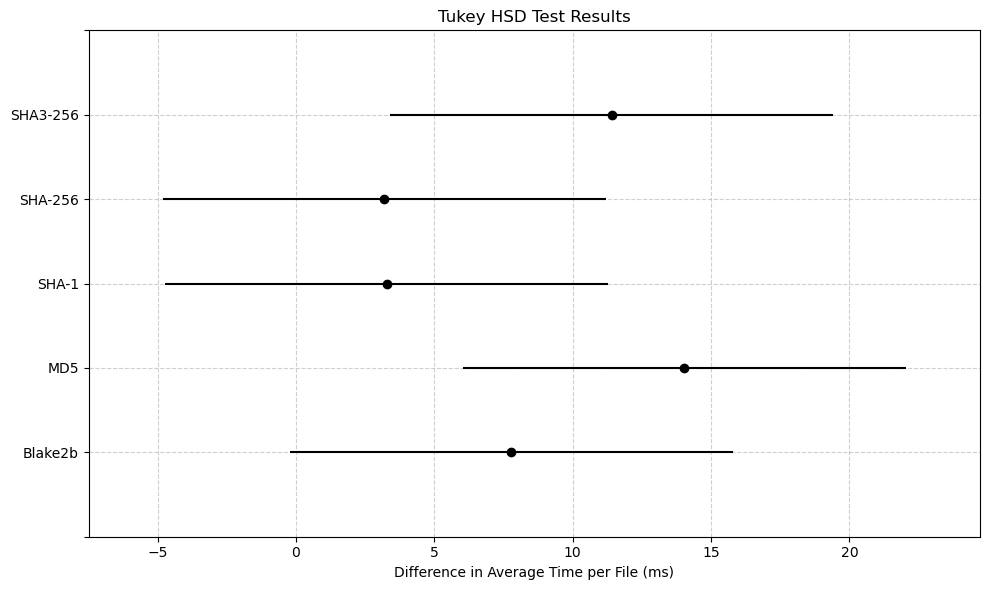

In [37]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Prepare the data for statistical analysis
def analyze_hashing_results(df):
    # Group by algorithm and calculate overall means
    grouped = df.groupby("Algorithm")["Average Time per File (ms)"]
    means = grouped.mean()
    
    # Prepare data for ANOVA
    algorithm_data = [df[df["Algorithm"] == alg]["Average Time per File (ms)"].values for alg in algorithms]

    # Perform ANOVA
    f_stat, p_value = f_oneway(*algorithm_data)

    print(f"ANOVA Results:\nF-statistic: {f_stat:.4f}, P-value: {p_value:.4e}")
    
    # Perform Tukey's HSD Test
    tukey = pairwise_tukeyhsd(
        endog=df["Average Time per File (ms)"],
        groups=df["Algorithm"],
        alpha=0.05
    )
    
    # Display Tukey's HSD results
    print("\nTukey HSD Pairwise Comparisons:")
    print(tukey)
    
    # Plot Tukey HSD results
    tukey.plot_simultaneous()
    plt.title("Tukey HSD Test Results")
    plt.xlabel("Difference in Average Time per File (ms)")
    plt.grid(visible=True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return f_stat, p_value, tukey

# Run the analysis
print("\n--- Statistical Analysis ---")
f_stat, p_value, tukey_results = analyze_hashing_results(df)


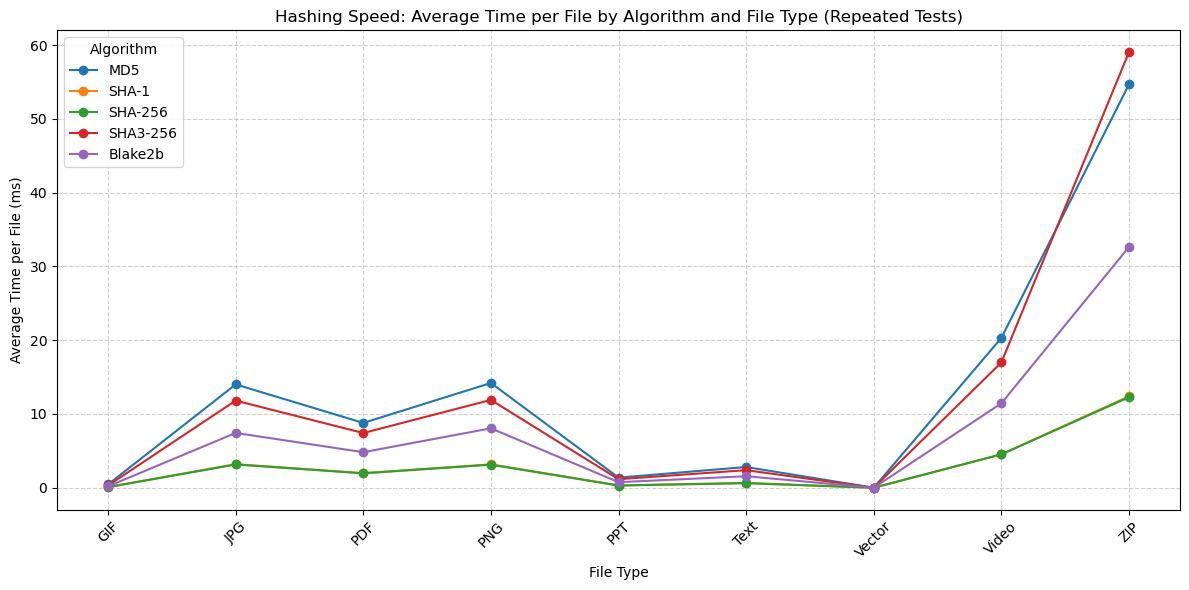

In [27]:
import matplotlib.pyplot as plt

# Prepare data for visualization
grouped_df = df.groupby(["File Type", "Algorithm"]).mean().reset_index()

# Visualization: Average Time per File for Each Algorithm and File Type
plt.figure(figsize=(12, 6))
for alg in algorithms:
    subset = grouped_df[grouped_df["Algorithm"] == alg]
    plt.plot(subset["File Type"], subset["Average Time per File (ms)"], marker='o', label=alg)

plt.title("Hashing Speed: Average Time per File by Algorithm and File Type (Repeated Tests)")
plt.xlabel("File Type")
plt.ylabel("Average Time per File (ms)")
plt.xticks(rotation=45)
plt.legend(title="Algorithm")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [24]:
import os
import time
import random
import string
import pandas as pd
from tabulate import tabulate
from cryptography.hazmat.primitives import hashes
import matplotlib.pyplot as plt

# Helper function to compute hash using a specific algorithm
def compute_hash(data, algorithm):
    if algorithm == "MD5":
        digest = hashes.Hash(hashes.MD5())
    elif algorithm == "SHA-1":
        digest = hashes.Hash(hashes.SHA1())
    elif algorithm == "SHA-256":
        digest = hashes.Hash(hashes.SHA256())
    elif algorithm == "SHA3-256":
        digest = hashes.Hash(hashes.SHA3_256())
    elif algorithm == "Blake2b":
        digest = hashes.Hash(hashes.BLAKE2b(64))  # 64 bytes = 512 bits output
    else:
        raise ValueError("Unsupported algorithm")
    digest.update(data)
    return digest.finalize()

# Generate random text files of specified sizes
def generate_random_text_files(sizes):
    files = []
    for size in sizes:
        data = "".join(random.choices(string.ascii_letters + string.digits, k=size)).encode()
        files.append(data)
    return files

# Measure hashing speed in MiBps, repeated trials
def measure_hashing_speed_mibps(algorithms, files, num_trials=10):
    results = []

    for alg in algorithms:
        for data in files:
            file_size_mib = len(data) / (1024 * 1024)  # Convert bytes to MiB
            trial_speeds = []
            
            for _ in range(num_trials):
                start_time = time.time()
                compute_hash(data, alg)
                elapsed_time = time.time() - start_time
                speed_mibps = file_size_mib / elapsed_time if elapsed_time > 0 else 0
                trial_speeds.append(speed_mibps)
            
            avg_speed = sum(trial_speeds) / len(trial_speeds)
            std_dev_speed = (sum((x - avg_speed) ** 2 for x in trial_speeds) / len(trial_speeds)) ** 0.5
            
            results.append({
                "Algorithm": alg,
                "File Size (MiB)": file_size_mib,
                "Average Speed (MiBps)": avg_speed,
                "Standard Deviation (MiBps)": std_dev_speed
            })
    return results

# Configuration
algorithms = ["MD5", "SHA-1", "SHA-256", "SHA3-256", "Blake2b"]
file_sizes = [1024, 10 * 1024, 100 * 1024, 1 * 1024 * 1024, 10 * 1024 * 1024, 100 * 1024 * 1024]  # Sizes in bytes (1 KB to 100 MB)

# Generate random text files
random_text_files = generate_random_text_files(file_sizes)

# Run the speed test
results = measure_hashing_speed_mibps(algorithms, random_text_files, num_trials=10)

# Create a DataFrame for results
df = pd.DataFrame(results)

# Display results
print("\nHashing Speed Test Results (MiBps):")
print(tabulate(df, headers="keys", tablefmt="grid"))




Hashing Speed Test Results (MiBps):
+----+-------------+-------------------+-------------------------+------------------------------+
|    | Algorithm   |   File Size (MiB) |   Average Speed (MiBps) |   Standard Deviation (MiBps) |
+====+=============+===================+=========================+==============================+
|  0 | MD5         |       0.000976562 |                 248.982 |                     93.4081  |
+----+-------------+-------------------+-------------------------+------------------------------+
|  1 | MD5         |       0.00976562  |                 522.186 |                     14.6385  |
+----+-------------+-------------------+-------------------------+------------------------------+
|  2 | MD5         |       0.0976562   |                 561.857 |                     17.6866  |
+----+-------------+-------------------+-------------------------+------------------------------+
|  3 | MD5         |       1           |                 546.757 |               

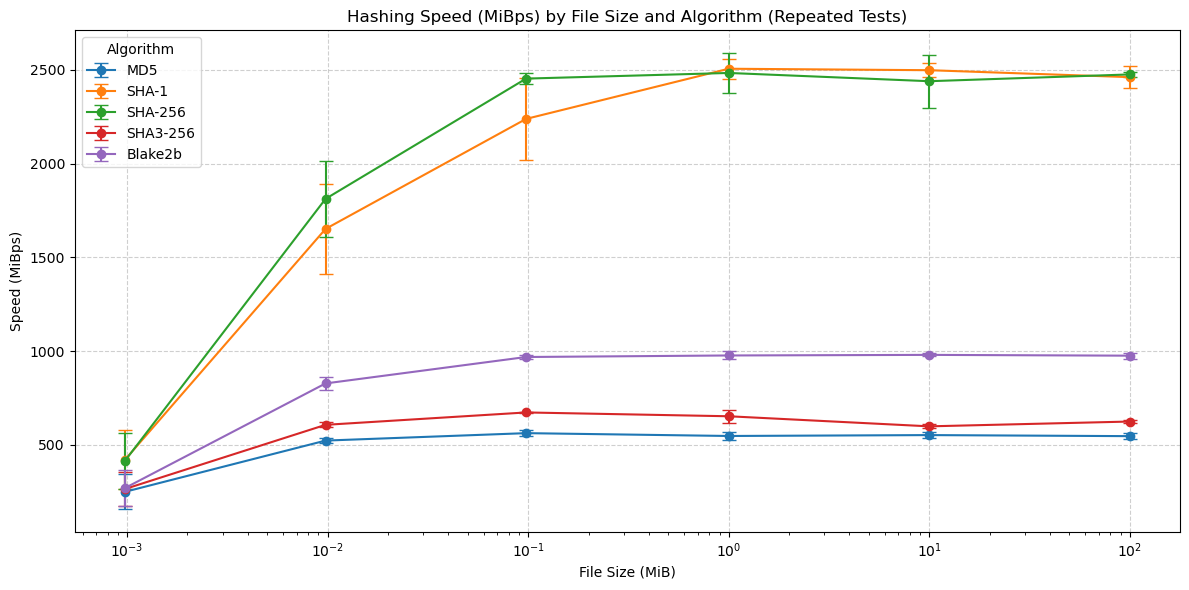

In [25]:
# Visualization
plt.figure(figsize=(12, 6))
for alg in algorithms:
    subset = df[df["Algorithm"] == alg]
    plt.errorbar(
        subset["File Size (MiB)"],
        subset["Average Speed (MiBps)"],
        yerr=subset["Standard Deviation (MiBps)"],
        fmt='-o',
        label=alg,
        capsize=5
    )

plt.title("Hashing Speed (MiBps) by File Size and Algorithm (Repeated Tests)")
plt.xlabel("File Size (MiB)")
plt.ylabel("Speed (MiBps)")
plt.xscale("log")
plt.legend(title="Algorithm")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [28]:
import time
import pandas as pd
from cryptography.hazmat.primitives import hashes
from tabulate import tabulate
import matplotlib.pyplot as plt

# Helper function to measure initialization time for a hashing algorithm
def measure_initialization_time(algorithm, num_trials=10):
    total_time = 0
    for _ in range(num_trials):
        start_time = time.time()
        if algorithm == "MD5":
            hashes.Hash(hashes.MD5())
        elif algorithm == "SHA-1":
            hashes.Hash(hashes.SHA1())
        elif algorithm == "SHA-256":
            hashes.Hash(hashes.SHA256())
        elif algorithm == "SHA3-256":
            hashes.Hash(hashes.SHA3_256())
        elif algorithm == "Blake2b":
            hashes.Hash(hashes.BLAKE2b(64))  # 64-byte output
        else:
            raise ValueError("Unsupported algorithm")
        total_time += time.time() - start_time
    avg_time = total_time / num_trials
    return avg_time

# Configuration
algorithms = ["MD5", "SHA-1", "SHA-256", "SHA3-256", "Blake2b"]
num_trials = 10

# Measure initialization times
results = []
for alg in algorithms:
    avg_init_time = measure_initialization_time(alg, num_trials)
    results.append({"Algorithm": alg, "Average Initialization Time (ms)": avg_init_time * 1000})

# Create a DataFrame for results
df = pd.DataFrame(results)

# Display results
print("\nInitialization Time Comparison:")
print(tabulate(df, headers="keys", tablefmt="grid"))




Initialization Time Comparison:
+----+-------------+------------------------------------+
|    | Algorithm   |   Average Initialization Time (ms) |
+====+=============+====================================+
|  0 | MD5         |                         0.0145674  |
+----+-------------+------------------------------------+
|  1 | SHA-1       |                         0.00379086 |
+----+-------------+------------------------------------+
|  2 | SHA-256     |                         0.00288486 |
+----+-------------+------------------------------------+
|  3 | SHA3-256    |                         0.0038147  |
+----+-------------+------------------------------------+
|  4 | Blake2b     |                         0.0056982  |
+----+-------------+------------------------------------+


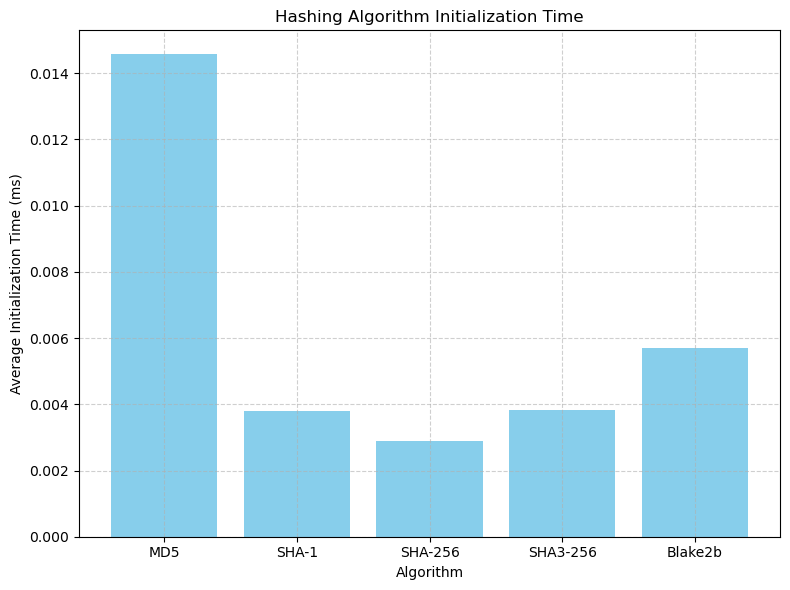

In [29]:
# Visualization
plt.figure(figsize=(8, 6))
plt.bar(df["Algorithm"], df["Average Initialization Time (ms)"], color="skyblue")
plt.title("Hashing Algorithm Initialization Time")
plt.xlabel("Algorithm")
plt.ylabel("Average Initialization Time (ms)")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [30]:
import os
import time
import random
import string
import pandas as pd
from cryptography.hazmat.primitives import hashes
from tabulate import tabulate
import matplotlib.pyplot as plt

# Helper function to compute hash using a specific algorithm
def compute_hash(data, algorithm):
    if algorithm == "MD5":
        digest = hashes.Hash(hashes.MD5())
    elif algorithm == "SHA-1":
        digest = hashes.Hash(hashes.SHA1())
    elif algorithm == "SHA-256":
        digest = hashes.Hash(hashes.SHA256())
    elif algorithm == "SHA3-256":
        digest = hashes.Hash(hashes.SHA3_256())
    elif algorithm == "Blake2b":
        digest = hashes.Hash(hashes.BLAKE2b(64))  # 64 bytes = 512 bits
    else:
        raise ValueError("Unsupported algorithm")
    digest.update(data)
    return digest.finalize()

# Generate random data of specified sizes
def generate_random_data(size_in_bytes):
    return os.urandom(size_in_bytes)

# Measure throughput in MiBps
def measure_throughput(algorithms, data_sizes, num_trials=5):
    results = []

    for alg in algorithms:
        for size in data_sizes:
            data = generate_random_data(size)
            file_size_mib = size / (1024 * 1024)  # Convert bytes to MiB
            trial_speeds = []

            for _ in range(num_trials):
                start_time = time.time()
                compute_hash(data, alg)
                elapsed_time = time.time() - start_time
                speed_mibps = file_size_mib / elapsed_time if elapsed_time > 0 else 0
                trial_speeds.append(speed_mibps)

            avg_speed = sum(trial_speeds) / len(trial_speeds)
            std_dev_speed = (sum((x - avg_speed) ** 2 for x in trial_speeds) / len(trial_speeds)) ** 0.5
            results.append({
                "Algorithm": alg,
                "File Size (MiB)": file_size_mib,
                "Average Throughput (MiBps)": avg_speed,
                "Standard Deviation (MiBps)": std_dev_speed
            })
    return results

# Configuration
algorithms = ["MD5", "SHA-1", "SHA-256", "SHA3-256", "Blake2b"]
data_sizes = [1024, 10 * 1024, 100 * 1024, 1 * 1024 * 1024, 10 * 1024 * 1024]  # Sizes in bytes (1 KB to 10 MB)
num_trials = 5  # Repeat each test 5 times for accuracy

# Run throughput test
results = measure_throughput(algorithms, data_sizes, num_trials)

# Create a DataFrame for results
df = pd.DataFrame(results)

# Display results
print("\nThroughput Test Results (MiBps):")
print(tabulate(df, headers="keys", tablefmt="grid"))




Throughput Test Results (MiBps):
+----+-------------+-------------------+------------------------------+------------------------------+
|    | Algorithm   |   File Size (MiB) |   Average Throughput (MiBps) |   Standard Deviation (MiBps) |
+====+=============+===================+==============================+==============================+
|  0 | MD5         |       0.000976562 |                      176.733 |                     95.3293  |
+----+-------------+-------------------+------------------------------+------------------------------+
|  1 | MD5         |       0.00976562  |                      377.331 |                    118.433   |
+----+-------------+-------------------+------------------------------+------------------------------+
|  2 | MD5         |       0.0976562   |                      341.381 |                     58.4705  |
+----+-------------+-------------------+------------------------------+------------------------------+
|  3 | MD5         |       1           

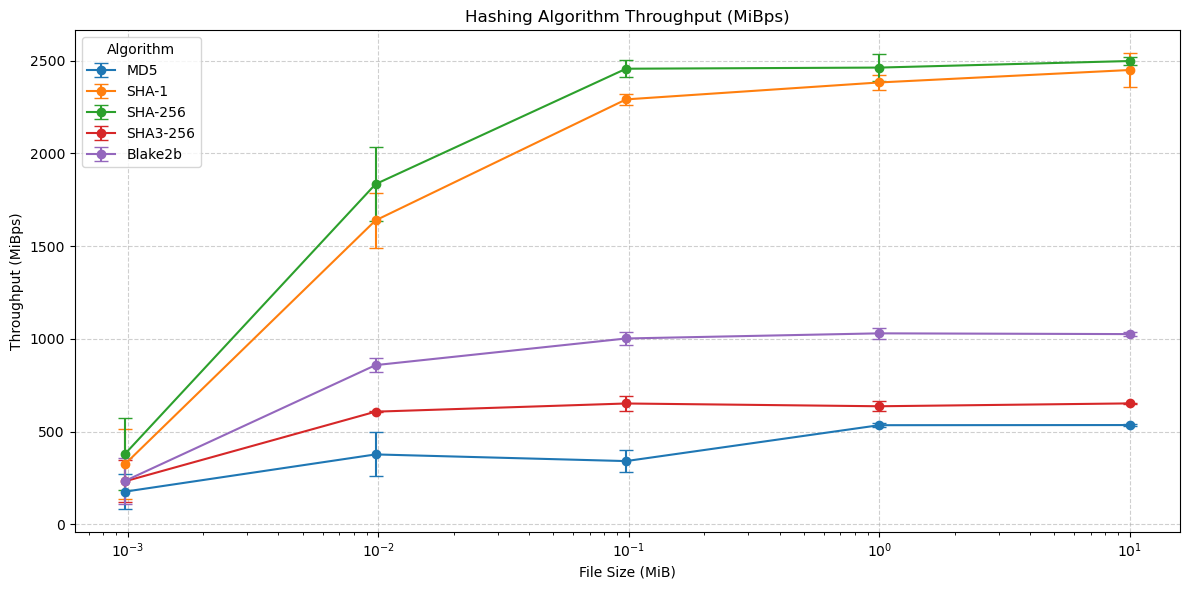

In [31]:
# Visualization
plt.figure(figsize=(12, 6))
for alg in algorithms:
    subset = df[df["Algorithm"] == alg]
    plt.errorbar(
        subset["File Size (MiB)"],
        subset["Average Throughput (MiBps)"],
        yerr=subset["Standard Deviation (MiBps)"],
        fmt='-o',
        label=alg,
        capsize=5
    )

plt.title("Hashing Algorithm Throughput (MiBps)")
plt.xlabel("File Size (MiB)")
plt.ylabel("Throughput (MiBps)")
plt.xscale("log")
plt.legend(title="Algorithm")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [39]:
import os
import time
import psutil  # For measuring CPU and memory usage
from cryptography.hazmat.primitives import hashes
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt

# Helper function to compute hash using a specific algorithm
def compute_hash(data, algorithm):
    if algorithm == "MD5":
        digest = hashes.Hash(hashes.MD5())
    elif algorithm == "SHA-1":
        digest = hashes.Hash(hashes.SHA1())
    elif algorithm == "SHA-256":
        digest = hashes.Hash(hashes.SHA256())
    elif algorithm == "SHA3-256":
        digest = hashes.Hash(hashes.SHA3_256())
    elif algorithm == "Blake2b":
        digest = hashes.Hash(hashes.BLAKE2b(64))  # 64 bytes = 512 bits
    else:
        raise ValueError("Unsupported algorithm")
    digest.update(data)
    return digest.finalize()

# Generate random data of specified sizes
def generate_random_data(size_in_bytes):
    return os.urandom(size_in_bytes)

# Measure CPU and memory usage
def measure_cpu_memory_usage(algorithms, data_sizes, num_trials=5):
    results = []

    for alg in algorithms:
        for size in data_sizes:
            data = generate_random_data(size)
            file_size_mib = size / (1024 * 1024)  # Convert bytes to MiB

            cpu_usages = []
            memory_usages = []

            for _ in range(num_trials):
                # Start monitoring CPU and memory
                process = psutil.Process(os.getpid())
                start_time = time.time()

                # Hash the data
                compute_hash(data, alg)

                # Measure CPU and memory usage
                cpu_usages.append(process.cpu_percent(interval=None))  # CPU usage as %
                memory_usages.append(process.memory_info().rss / (1024 * 1024))  # Memory usage in MiB

            avg_cpu_usage = sum(cpu_usages) / len(cpu_usages)
            avg_memory_usage = sum(memory_usages) / len(memory_usages)

            results.append({
                "Algorithm": alg,
                "File Size (MiB)": file_size_mib,
                "Average CPU Usage (%)": avg_cpu_usage,
                "Average Memory Usage (MiB)": avg_memory_usage,
                "Trials": num_trials
            })

    return results

# Configuration
algorithms = ["MD5", "SHA-1", "SHA-256", "SHA3-256", "Blake2b"]
data_sizes = [1024, 10 * 1024, 100 * 1024, 1 * 1024 * 1024]  # Sizes in bytes (1 KB to 1 MB)
num_trials = 5  # Repeat each test 5 times

# Run CPU and memory usage test
results = measure_cpu_memory_usage(algorithms, data_sizes, num_trials)

# Create a DataFrame for results
df = pd.DataFrame(results)

# Display results
print("\nCPU and Memory Usage Test Results:")
print(tabulate(df, headers="keys", tablefmt="grid"))



CPU and Memory Usage Test Results:
+----+-------------+-------------------+-------------------------+------------------------------+----------+
|    | Algorithm   |   File Size (MiB) |   Average CPU Usage (%) |   Average Memory Usage (MiB) |   Trials |
+====+=============+===================+=========================+==============================+==========+
|  0 | MD5         |       0.000976562 |                       0 |                      351.047 |        5 |
+----+-------------+-------------------+-------------------------+------------------------------+----------+
|  1 | MD5         |       0.00976562  |                       0 |                      351.047 |        5 |
+----+-------------+-------------------+-------------------------+------------------------------+----------+
|  2 | MD5         |       0.0976562   |                       0 |                      351.047 |        5 |
+----+-------------+-------------------+-------------------------+--------------------------


--- Memory Usage ANOVA ---
ANOVA Results for Memory Usage:
F-statistic: 24.7387, P-value: 1.8663e-06


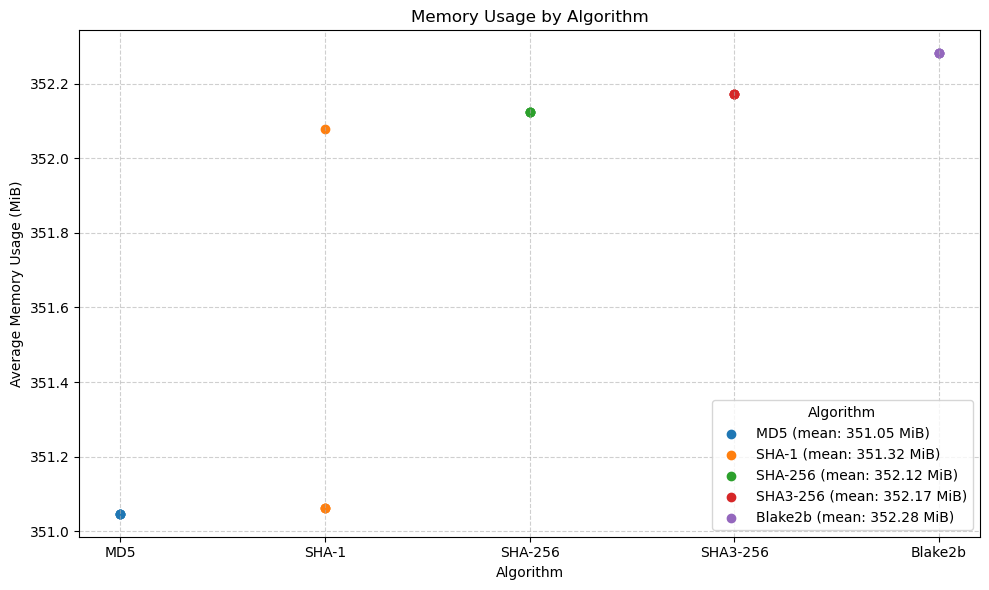

In [40]:
from scipy.stats import f_oneway
import matplotlib.pyplot as plt

# Prepare data for ANOVA
def perform_memory_usage_anova(df):
    # Filter relevant columns
    memory_data = {alg: df[df["Algorithm"] == alg]["Average Memory Usage (MiB)"].values for alg in algorithms}
    
    # Perform ANOVA
    anova_data = list(memory_data.values())
    f_stat, p_value = f_oneway(*anova_data)

    print(f"ANOVA Results for Memory Usage:\nF-statistic: {f_stat:.4f}, P-value: {p_value:.4e}")
    
    # Plot memory usage
    plt.figure(figsize=(10, 6))
    for alg, usage in memory_data.items():
        plt.scatter([alg] * len(usage), usage, label=f"{alg} (mean: {usage.mean():.2f} MiB)")
    plt.title("Memory Usage by Algorithm")
    plt.xlabel("Algorithm")
    plt.ylabel("Average Memory Usage (MiB)")
    plt.legend(title="Algorithm")
    plt.grid(visible=True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return f_stat, p_value

# Run the ANOVA analysis
print("\n--- Memory Usage ANOVA ---")
f_stat, p_value = perform_memory_usage_anova(df)


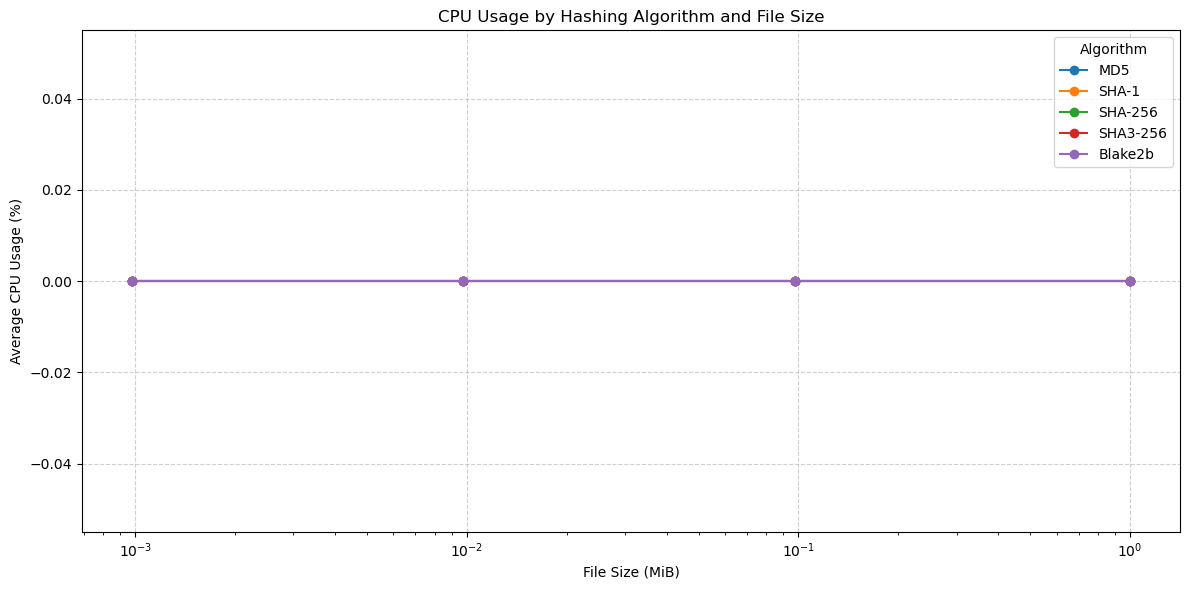

In [33]:
# Visualization: CPU Usage
plt.figure(figsize=(12, 6))
for alg in algorithms:
    subset = df[df["Algorithm"] == alg]
    plt.plot(
        subset["File Size (MiB)"],
        subset["Average CPU Usage (%)"],
        marker='o',
        label=alg
    )
plt.title("CPU Usage by Hashing Algorithm and File Size")
plt.xlabel("File Size (MiB)")
plt.ylabel("Average CPU Usage (%)")
plt.xscale("log")
plt.legend(title="Algorithm")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

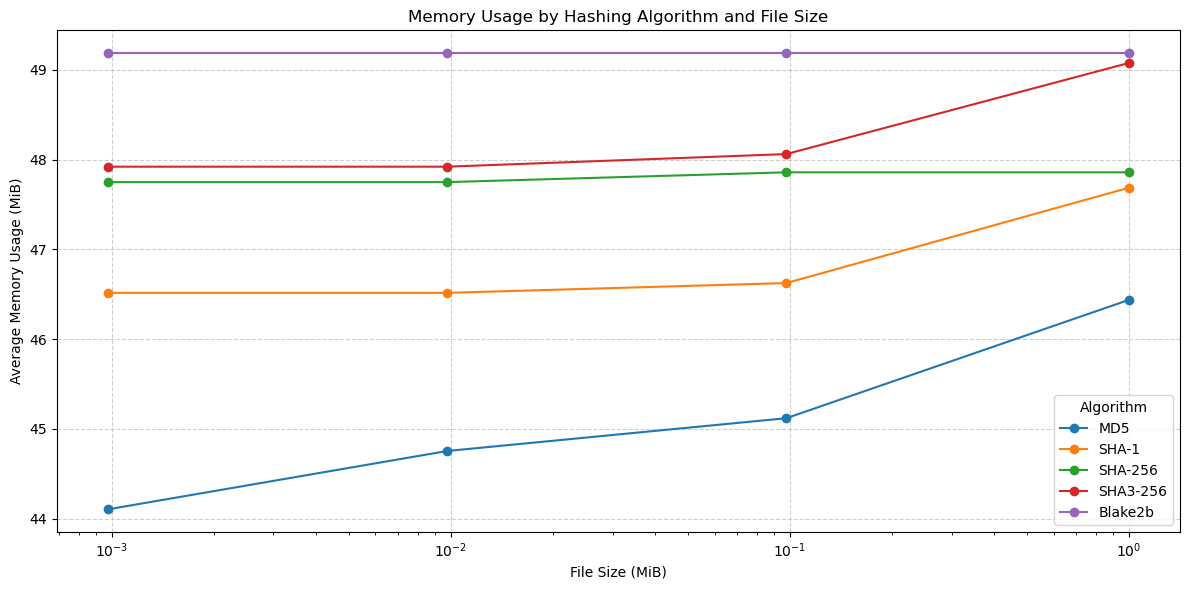

In [34]:
# Visualization: Memory Usage
plt.figure(figsize=(12, 6))
for alg in algorithms:
    subset = df[df["Algorithm"] == alg]
    plt.plot(
        subset["File Size (MiB)"],
        subset["Average Memory Usage (MiB)"],
        marker='o',
        label=alg
    )
plt.title("Memory Usage by Hashing Algorithm and File Size")
plt.xlabel("File Size (MiB)")
plt.ylabel("Average Memory Usage (MiB)")
plt.xscale("log")
plt.legend(title="Algorithm")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



Computational Resource Usage Results:
+----+-------------+-------------------+-------------------------+------------------------------+-------------------------------+----------------------+----------+
|    | Algorithm   |   File Size (MiB) |   Average CPU Usage (%) |   Average Memory Usage (MiB) |   Average Execution Time (ms) |   Throughput (MiBps) |   Trials |
+====+=============+===================+=========================+==============================+===============================+======================+==========+
|  0 | MD5         |       0.000976562 |                       0 |                      44.0719 |                    0.0485897  |              20.0981 |        5 |
+----+-------------+-------------------+-------------------------+------------------------------+-------------------------------+----------------------+----------+
|  1 | MD5         |       0.00976562  |                       0 |                      44.2656 |                    0.0350475  |            

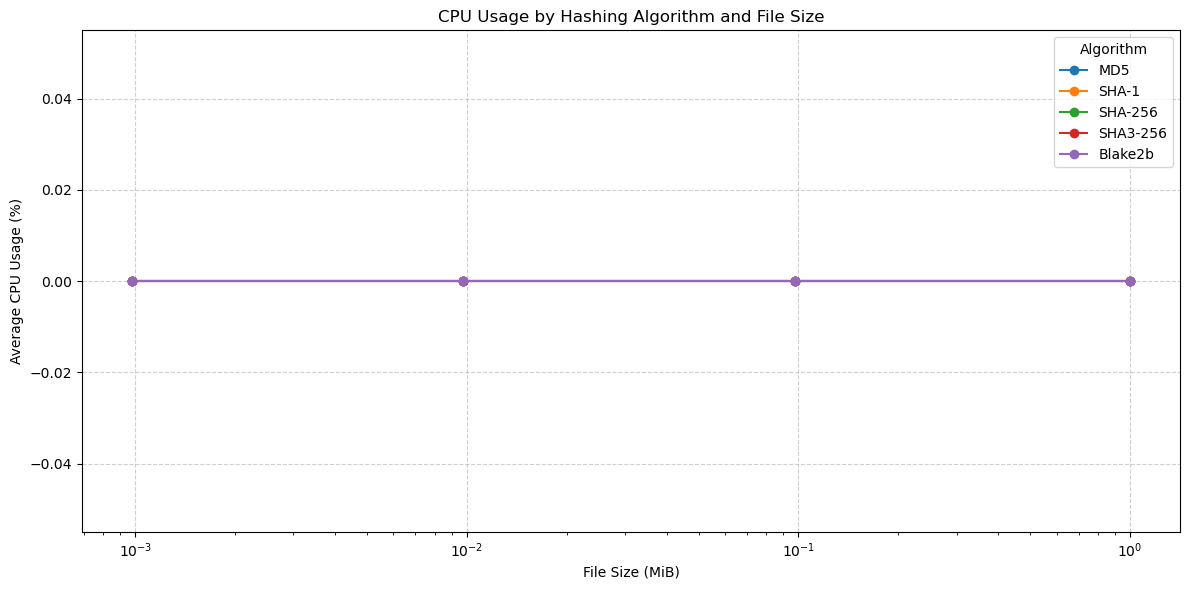

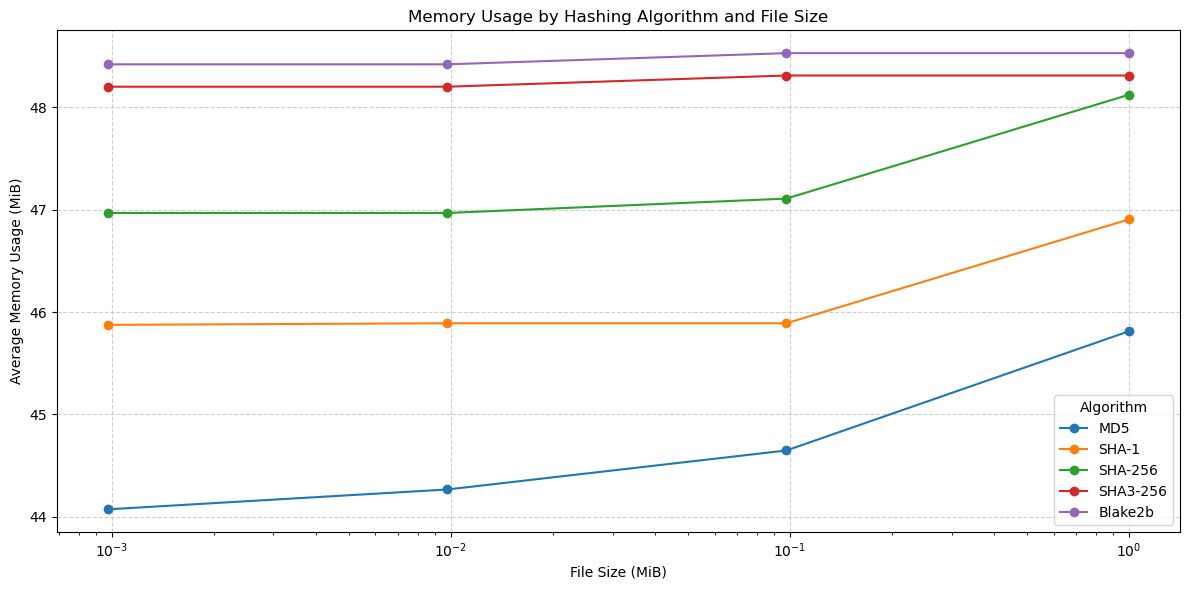

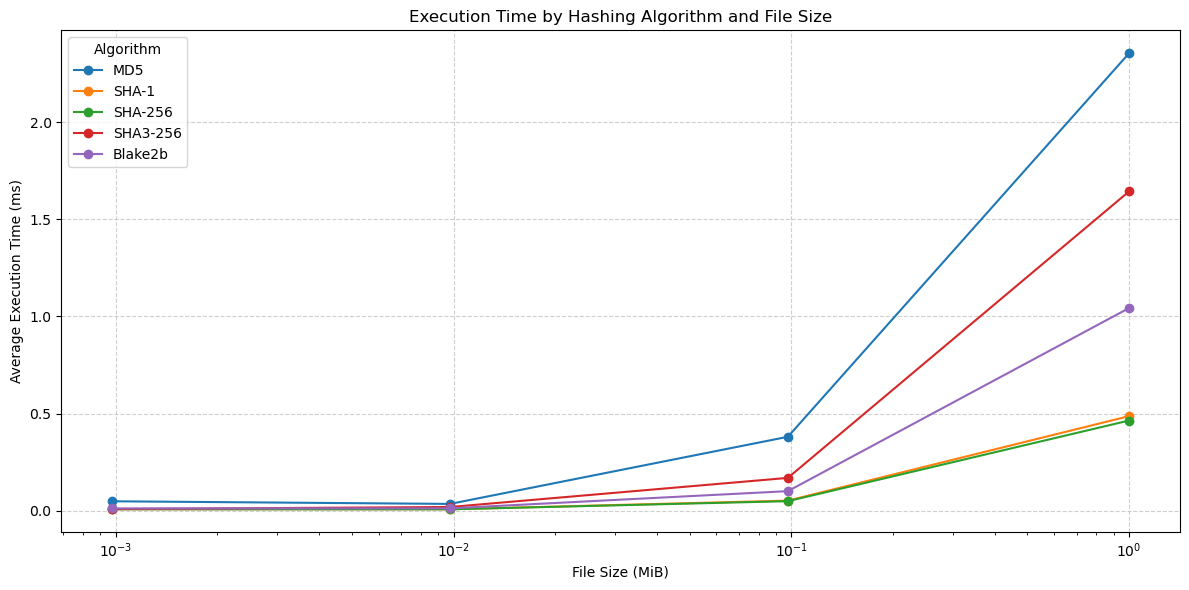

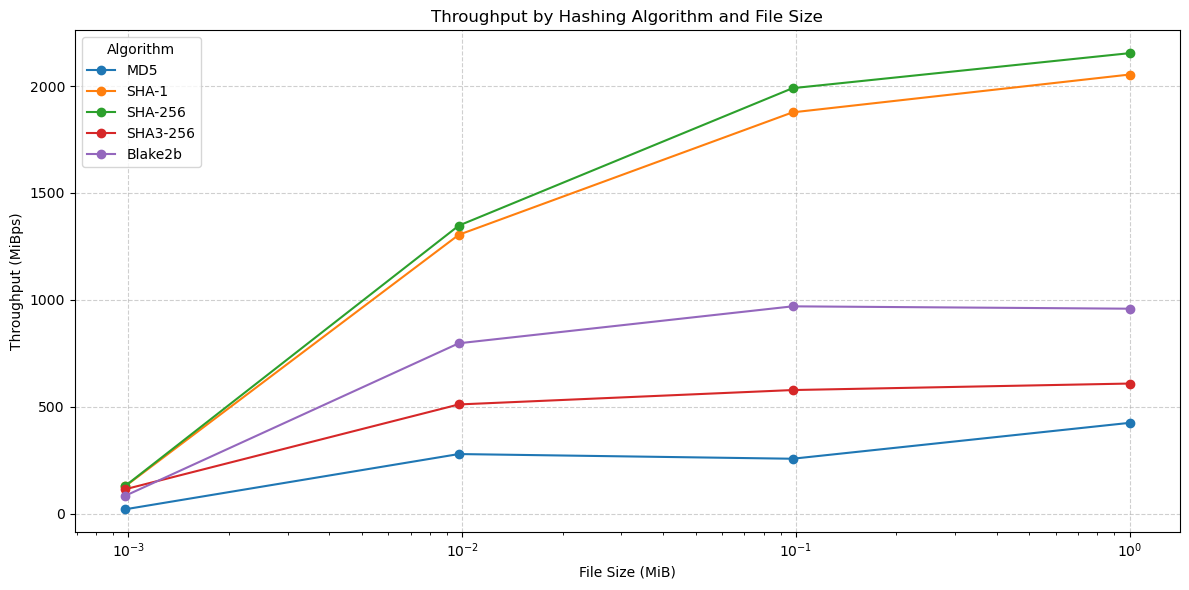

In [35]:
import os
import time
import psutil  # For measuring CPU and memory usage
from cryptography.hazmat.primitives import hashes
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt

# Helper function to compute hash using a specific algorithm
def compute_hash(data, algorithm):
    if algorithm == "MD5":
        digest = hashes.Hash(hashes.MD5())
    elif algorithm == "SHA-1":
        digest = hashes.Hash(hashes.SHA1())
    elif algorithm == "SHA-256":
        digest = hashes.Hash(hashes.SHA256())
    elif algorithm == "SHA3-256":
        digest = hashes.Hash(hashes.SHA3_256())
    elif algorithm == "Blake2b":
        digest = hashes.Hash(hashes.BLAKE2b(64))  # 64 bytes = 512 bits
    else:
        raise ValueError("Unsupported algorithm")
    digest.update(data)
    return digest.finalize()

# Generate random data of specified sizes
def generate_random_data(size_in_bytes):
    return os.urandom(size_in_bytes)

# Measure computational resource usage
def measure_resource_usage(algorithms, data_sizes, num_trials=5):
    results = []

    for alg in algorithms:
        for size in data_sizes:
            data = generate_random_data(size)
            file_size_mib = size / (1024 * 1024)  # Convert bytes to MiB

            cpu_usages = []
            memory_usages = []
            execution_times = []

            for _ in range(num_trials):
                # Start monitoring
                process = psutil.Process(os.getpid())

                # Measure execution time
                start_time = time.time()
                compute_hash(data, alg)
                elapsed_time = time.time() - start_time

                # Measure CPU and memory usage
                cpu_usage = process.cpu_percent(interval=None)  # CPU usage as %
                memory_usage = process.memory_info().rss / (1024 * 1024)  # Memory usage in MiB

                cpu_usages.append(cpu_usage)
                memory_usages.append(memory_usage)
                execution_times.append(elapsed_time)

            # Calculate averages
            avg_cpu_usage = sum(cpu_usages) / len(cpu_usages)
            avg_memory_usage = sum(memory_usages) / len(memory_usages)
            avg_execution_time = sum(execution_times) / len(execution_times)
            throughput = file_size_mib / avg_execution_time if avg_execution_time > 0 else 0

            results.append({
                "Algorithm": alg,
                "File Size (MiB)": file_size_mib,
                "Average CPU Usage (%)": avg_cpu_usage,
                "Average Memory Usage (MiB)": avg_memory_usage,
                "Average Execution Time (ms)": avg_execution_time * 1000,
                "Throughput (MiBps)": throughput,
                "Trials": num_trials
            })

    return results

# Configuration
algorithms = ["MD5", "SHA-1", "SHA-256", "SHA3-256", "Blake2b"]
data_sizes = [1024, 10 * 1024, 100 * 1024, 1 * 1024 * 1024]  # Sizes in bytes (1 KB to 1 MB)
num_trials = 5  # Repeat each test 5 times

# Run computational resource usage test
results = measure_resource_usage(algorithms, data_sizes, num_trials)

# Create a DataFrame for results
df = pd.DataFrame(results)

# Display results
print("\nComputational Resource Usage Results:")
print(tabulate(df, headers="keys", tablefmt="grid"))

# Visualization: CPU Usage
plt.figure(figsize=(12, 6))
for alg in algorithms:
    subset = df[df["Algorithm"] == alg]
    plt.plot(
        subset["File Size (MiB)"],
        subset["Average CPU Usage (%)"],
        marker='o',
        label=alg
    )
plt.title("CPU Usage by Hashing Algorithm and File Size")
plt.xlabel("File Size (MiB)")
plt.ylabel("Average CPU Usage (%)")
plt.xscale("log")
plt.legend(title="Algorithm")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Visualization: Memory Usage
plt.figure(figsize=(12, 6))
for alg in algorithms:
    subset = df[df["Algorithm"] == alg]
    plt.plot(
        subset["File Size (MiB)"],
        subset["Average Memory Usage (MiB)"],
        marker='o',
        label=alg
    )
plt.title("Memory Usage by Hashing Algorithm and File Size")
plt.xlabel("File Size (MiB)")
plt.ylabel("Average Memory Usage (MiB)")
plt.xscale("log")
plt.legend(title="Algorithm")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Visualization: Execution Time
plt.figure(figsize=(12, 6))
for alg in algorithms:
    subset = df[df["Algorithm"] == alg]
    plt.plot(
        subset["File Size (MiB)"],
        subset["Average Execution Time (ms)"],
        marker='o',
        label=alg
    )
plt.title("Execution Time by Hashing Algorithm and File Size")
plt.xlabel("File Size (MiB)")
plt.ylabel("Average Execution Time (ms)")
plt.xscale("log")
plt.legend(title="Algorithm")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Visualization: Throughput
plt.figure(figsize=(12, 6))
for alg in algorithms:
    subset = df[df["Algorithm"] == alg]
    plt.plot(
        subset["File Size (MiB)"],
        subset["Throughput (MiBps)"],
        marker='o',
        label=alg
    )
plt.title("Throughput by Hashing Algorithm and File Size")
plt.xlabel("File Size (MiB)")
plt.ylabel("Throughput (MiBps)")
plt.xscale("log")
plt.legend(title="Algorithm")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
